Day 1, Hour 8: Arrival Rate 15, Inter-Arrival Time 0.73
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 0.06
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 4.65
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 8.61
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 2.41
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 6.26
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 6.42
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 1.61
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 5.26
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 0.96
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 0.43
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 11.01
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 0.57
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 1.71
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 4.55
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 3.03
Day 1, Hour 8.0: Arrival Rate 15, Inter-Arrival Time 3.82
Day 1, Hour 9.0

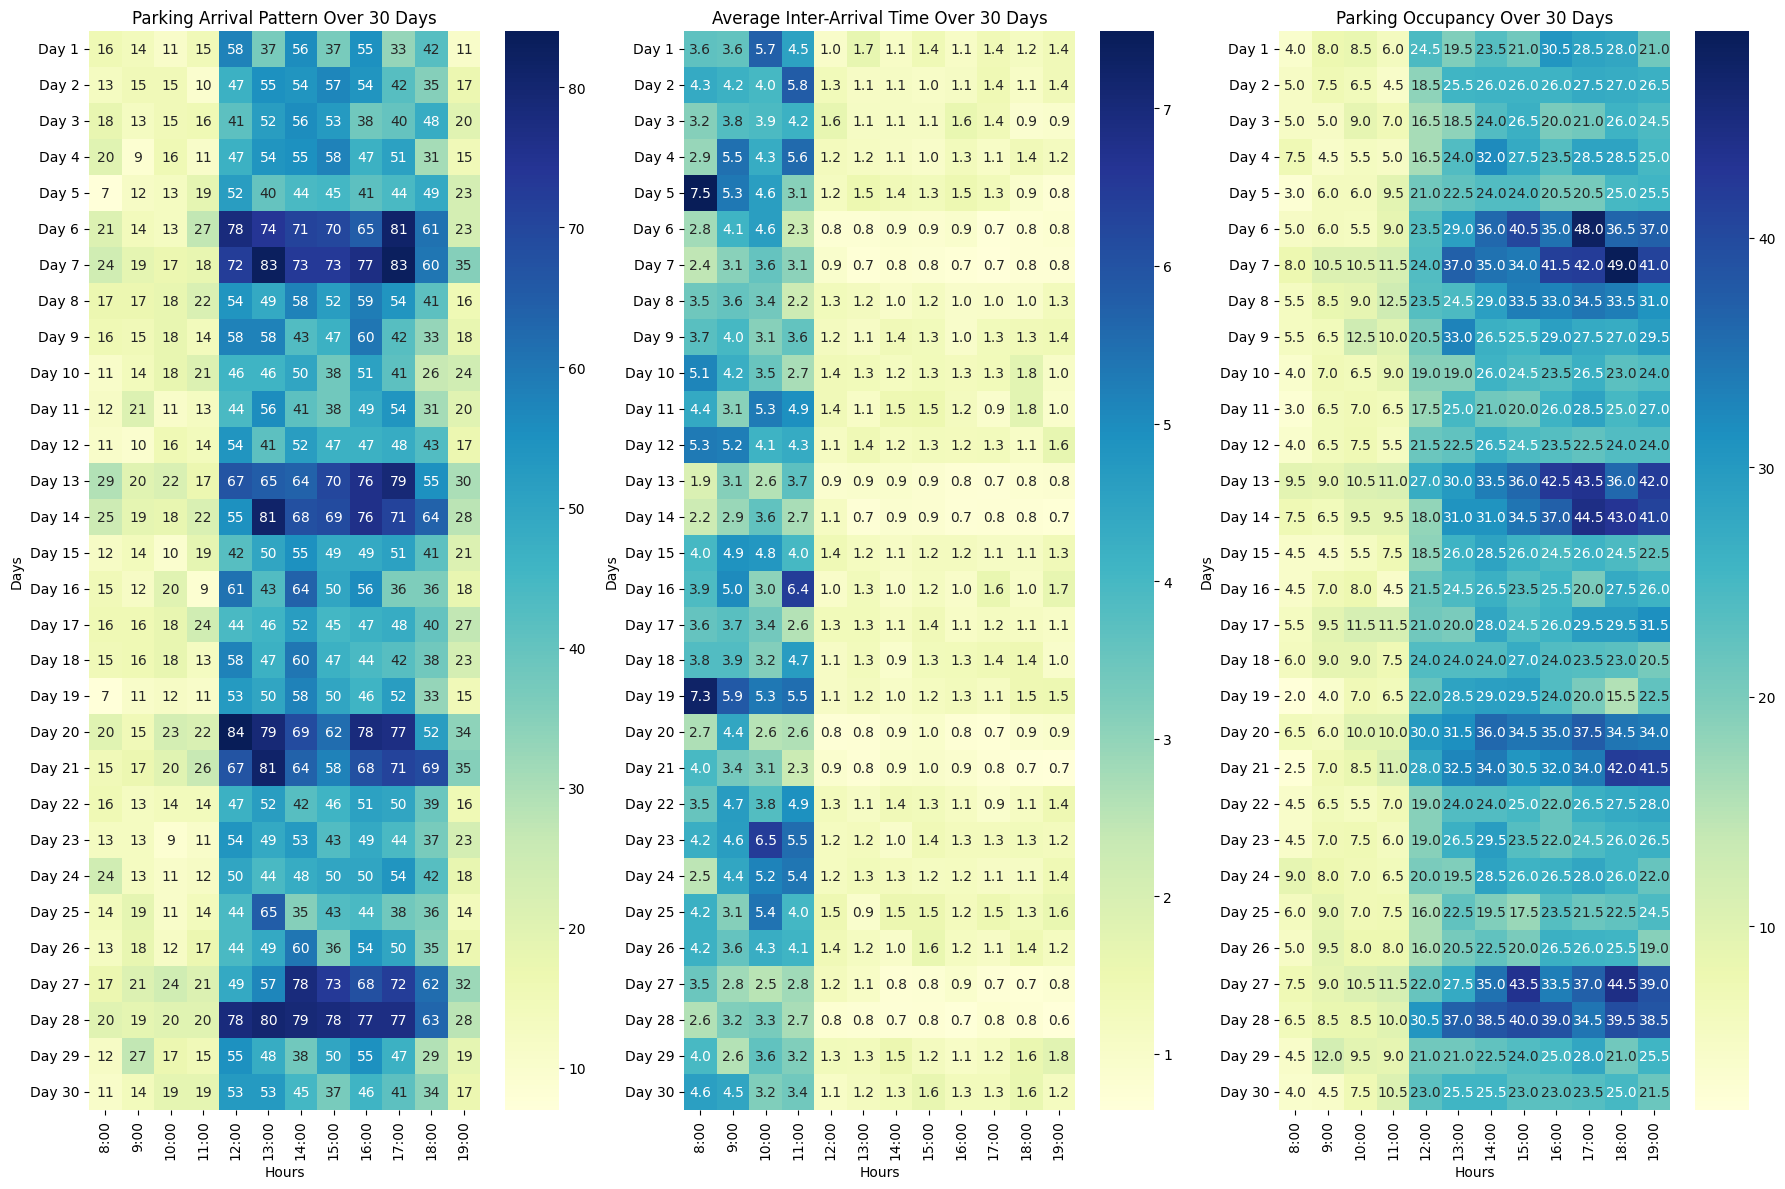

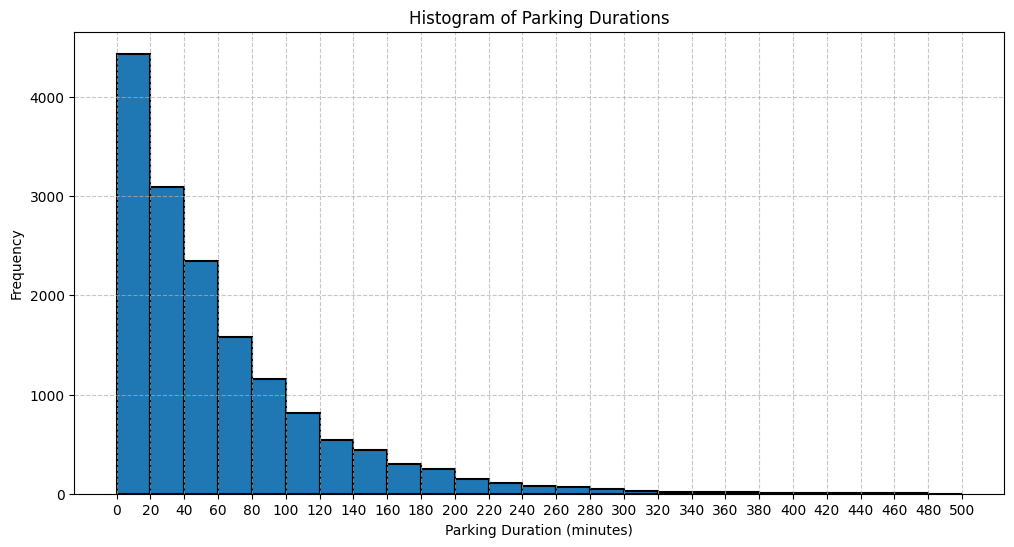

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
DAYS = 30
HOURS_PER_DAY = 12  # From 8 AM to 8 PM
CAPACITY = 200

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Monday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Tuesday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Wednesday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Thursday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Friday': [(8, 12, 20), (12, 17, 70), (17, 20, 80)],
    'Saturday': [(8, 12, 20), (12, 17, 70), (17, 20, 80)]
}

# Initialize data for tracking arrivals, inter-arrival times, parking durations, revenue, and parking space utilization
arrival_pattern = np.zeros((DAYS, HOURS_PER_DAY))  # 30 days, 12 hours per day (8 AM to 8 PM)
inter_arrival_times = [[] for _ in range(DAYS * HOURS_PER_DAY)]  # List of lists for storing inter-arrival times for each time slot
parking_durations = []  # List to store parking durations
total_revenue = 0  # Total revenue accumulator
occupancy_data = np.zeros((DAYS, HOURS_PER_DAY))  # Data for tracking parking occupancy

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def calculate_charge(parking_duration):
    """Calculate the charge based on parking duration with ceiling logic."""
    if parking_duration < 30:
        return 15
    else:
        hours = np.ceil(parking_duration / 60)  # Round up to the nearest hour
        return 25 * hours  # Charge ₹25 per hour

def vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time):
    """Simulates vehicle parking behavior, tracks arrivals, inter-arrival times, and calculates revenue."""
    global total_revenue
    
    # Generate parking duration (in minutes)
    parking_duration = np.random.exponential(60)  # Exponential distribution with mean 60 minutes
    
    # Store parking duration
    parking_durations.append(parking_duration)
    
    # Calculate the charge based on parking duration
    charge = calculate_charge(parking_duration)
    
    # Update total revenue
    total_revenue += charge
    
    with parking_lot.request() as request:
        yield request
        # Update occupancy data
        current_time = env.now
        num_vehicles = len(parking_lot.users)
        hour = (current_time // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        hour_index = int(hour - 8)  # Adjust index to match 0-11 range
        occupancy_data[day_index, hour_index] = num_vehicles / CAPACITY * 100
        yield env.timeout(parking_duration)
        # Track arrivals for the specific day and hour
        arrival_pattern[day_index, hour_index] += 1  # Use correct indexing for Numpy arrays
        # Store the inter-arrival time
        inter_arrival_times[day_index * HOURS_PER_DAY + hour_index].append(inter_arrival_time)

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    while env.now < HOURS_PER_DAY * 60:  # Simulate only 12 hours of the current day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)
        
        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range
        
        if 0 <= hour_index < HOURS_PER_DAY:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                print(f"Day {day_index+1}, Hour {current_hour}: Arrival Rate {rate}, Inter-Arrival Time {inter_arrival_time:.2f}")
                yield env.timeout(inter_arrival_time)
                env.process(vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time))
            else:
                yield env.timeout(1)  # Wait for 1 minute if no arrival

def run_simulation():
    """Runs the simulation for 30 days."""
    global total_revenue
    for day_index in range(DAYS):
        env = simpy.Environment()
        parking_lot = simpy.Resource(env, capacity=CAPACITY)
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))
        # Simulate 12 hours of the current day
        env.run(until=HOURS_PER_DAY * 60)

# Run the simulation
run_simulation()

# Calculate average inter-arrival time for each time slot
average_inter_arrival = np.zeros((DAYS, HOURS_PER_DAY))  # 30 days, 12 hours per day

for i in range(DAYS):
    for j in range(HOURS_PER_DAY):
        if inter_arrival_times[i * HOURS_PER_DAY + j]:  # Check if there are any inter-arrival times recorded
            average_inter_arrival[i, j] = np.mean(inter_arrival_times[i * HOURS_PER_DAY + j])

# Create DataFrames for the heatmaps
hours = [f"{hour}:00" for hour in range(8, 20)]  # Hour labels from 8 AM to 8 PM
days = [f"Day {i+1}" for i in range(DAYS)]
arrival_df = pd.DataFrame(arrival_pattern, index=days, columns=hours)
average_inter_arrival_df = pd.DataFrame(average_inter_arrival, index=days, columns=hours)
occupancy_df = pd.DataFrame(occupancy_data, index=days, columns=hours)

# Print arrival pattern, average inter-arrival time, total revenue, and time slot utilization
print("Parking Arrival Pattern Over 30 Days:")
print(arrival_df)
print("\nAverage Inter-Arrival Time (in minutes) Over 30 Days:")
print(average_inter_arrival_df)
print(f"\nTotal Revenue Over 30 Days: ₹{total_revenue:.2f}")

# Calculate parking space utilization for each time slot
time_slot_utilization = {
    '8-11:59': 0,
    '12-16:59': 0,
    '17-20:00': 0
}

# Utility function to get time slot based on the hour
def get_time_slot(hour):
    if 8 <= hour < 12:
        return '8-11:59'
    elif 12 <= hour < 17:
        return '12-16:59'
    elif 17 <= hour < 20:
        return '17-20:00'
    return None

# Compute the total occupied time based on occupancy data and categorize by time slots
for day_index in range(DAYS):
    for hour_index in range(HOURS_PER_DAY):
        slot = get_time_slot(hour_index + 8)
        if slot:
            time_in_slot = 60  # Each hour slot is 60 minutes
            time_slot_utilization[slot] += (occupancy_data[day_index, hour_index] / 100) * time_in_slot

# Print average parking space utilization by time slot
total_time_per_slot = {
    '8-11:59': 4 * 60 * DAYS,  # 4 hours per day, 30 days
    '12-16:59': 5 * 60 * DAYS,  # 5 hours per day, 30 days
    '17-20:00': 3 * 60 * DAYS   # 3 hours per day, 30 days
}

average_utilization_by_slot = {slot: (utilization / total_time_per_slot[slot]) * 100
                               for slot, utilization in time_slot_utilization.items()}

print("\nAverage Parking Space Utilization by Time Slot:")
for slot, utilization in average_utilization_by_slot.items():
    print(f"{slot}: {utilization:.2f}%")

# Plotting the heatmaps
plt.figure(figsize=(18, 12))

# Heatmap for parking arrival pattern
plt.subplot(1, 3, 1)
sns.heatmap(arrival_df, annot=True, cmap="YlGnBu", cbar=True, fmt=".0f")
plt.title("Parking Arrival Pattern Over 30 Days")
plt.xlabel("Hours")
plt.ylabel("Days")

# Heatmap for average inter-arrival time
plt.subplot(1, 3, 2)
sns.heatmap(average_inter_arrival_df, annot=True, cmap="YlGnBu", cbar=True, fmt=".1f")
plt.title("Average Inter-Arrival Time Over 30 Days")
plt.xlabel("Hours")
plt.ylabel("Days")

# Heatmap for parking occupancy
plt.subplot(1, 3, 3)
sns.heatmap(occupancy_df, annot=True, cmap="YlGnBu", cbar=True, fmt=".1f")
plt.title("Parking Occupancy Over 30 Days")
plt.xlabel("Hours")
plt.ylabel("Days")

plt.tight_layout()
plt.show()

# Plot parking duration histogram
plt.figure(figsize=(12, 6))
max_duration = int(max(parking_durations))
bins = range(0, max_duration + 10, 20)  # Create bins with 20-minute intervals
plt.hist(parking_durations, bins=bins, edgecolor='black', linewidth=1.5)  # Increased linewidth

# Customizing x-ticks to show intervals of 20 minutes
plt.xticks(bins)

plt.title("Histogram of Parking Durations")
plt.xlabel("Parking Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines for better readability

plt.show()
